# ECS 271: HW2
### Daniel Scalettar

## Load and normalize CIFAR10 

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Display some random training images

  car horse plane  frog


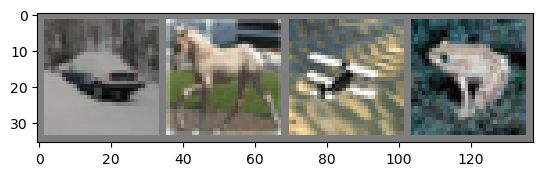

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Define a Convolutional Neural Network

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define a Loss function and optimizer

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.154
[1,  4000] loss: 1.820
[1,  6000] loss: 1.664
[1,  8000] loss: 1.565
[1, 10000] loss: 1.510
[1, 12000] loss: 1.493
[2,  2000] loss: 1.420
[2,  4000] loss: 1.387
[2,  6000] loss: 1.362
[2,  8000] loss: 1.346
[2, 10000] loss: 1.301
[2, 12000] loss: 1.294
Finished Training


## Test network on test data

GroundTruth:    cat  ship  ship plane
Predicted:    cat   car   car plane


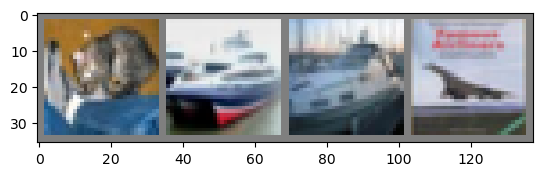

In [11]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

########################################################################
# Okay, now let us see what the neural network thinks these examples above are:

outputs = net(images)

########################################################################
# The outputs are energies for the 10 classes.
# Higher the energy for a class, the more the network
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [31]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

########################################################################
# That looks waaay better than chance, which is 10% accuracy (randomly picking
# a class out of 10 classes).
# Seems like the network learnt something.
#
# Hmmm, what are the classes that performed well, and the classes that did
# not perform well:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 52 %
Accuracy of plane : 67 %
Accuracy of   car : 53 %
Accuracy of  bird : 26 %
Accuracy of   cat : 12 %
Accuracy of  deer : 49 %
Accuracy of   dog : 57 %
Accuracy of  frog : 51 %
Accuracy of horse : 75 %
Accuracy of  ship : 55 %
Accuracy of truck : 76 %


In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cpu


# 0. Setup and Infrustructure

## 0.1 Imports and Device Selection 

Select device based on availability.
Use MPS or CUDA if possible for improved performance.

In [34]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device selection
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using MPS device


## 0.2 Load Data

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## 0.3 Define Helper Functions

In [75]:
def get_dataloaders(batch_size, num_workers=2):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers)
    return trainloader, testloader

In [74]:
def train_and_evaluate(model, trainloader, testloader, criterion, optimizer, device, epochs=2):
    # parameters to track during training
    train_loss_history = []
    train_acc_history = []
    test_acc_history = []
    best_test_acc = 0.0
    # training loop
    for epoch in range(epochs):
        # set training mode
        model.train()
        # initialize parameters to track training accuracy
        train_total = 0
        train_correct = 0
        running_loss_epoch = 0.0
        running_loss_intermediate = 0.0
        # iterate over training data
        for i, data in enumerate(trainloader, 0):
            # get the inputs and move them to selected device
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            # print statistics
            running_loss_intermediate += loss.item()
            running_loss_epoch += loss.item()
            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss_intermediate / 2000))
                running_loss_intermediate = 0.0
        # calculate epoch loss and training accuracy
        epoch_loss = running_loss_epoch / len(trainloader)
        epoch_train_acc = 100 * train_correct / train_total
        # set model to evaluate mode and evaluate on test data
        model.eval()
        test_total = 0
        test_correct = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()
        # calculate test accuracy and update histories
        epoch_test_acc = 100 * test_correct / test_total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_train_acc)
        test_acc_history.append(epoch_test_acc)
        # output epoch statistics
        print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {epoch_loss:.3f}, Train Acc: {epoch_train_acc:.3f}%, Test Acc: {epoch_test_acc:.3f}%")
        # track best test accuracy
        if epoch_test_acc >= best_test_acc:
            best_test_acc = epoch_test_acc
    # output best test accuracy and return histories
    print(f"Best Test Acc: {best_test_acc:.3f}%")
    return train_loss_history, train_acc_history, test_acc_history

In [72]:
def plot_results(title, loss, train_acc, test_acc):
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(14, 6))
    
    # Plot 1: Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.title(f'Loss vs. Epochs: {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy')
    plt.plot(epochs, test_acc, label='Test Accuracy')
    plt.title(f'Accuracy vs. Epochs: {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [53]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 1. CNN Baseline Model

## 1.1 Model Definition

In [54]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # input: 3x32x32
        self.conv1 = nn.Conv2d(3, 6, 5) # output: 6x28x28
        self.pool = nn.MaxPool2d(2, 2) # output: 6x14x14
        self.conv2 = nn.Conv2d(6, 16, 5) # output: 16x10x10
        # output (after another pool): 16x5x5
        # fully connected layer input: 16*5*5=400
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        # output: 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 1.2 Train and Evaluate Baseline Model

In [ ]:
net_base = Net()
net_base.to(device)

trainloader_base, testloader_base = get_dataloaders(batch_size=4, num_workers=2)

criterion_base = nn.CrossEntropyLoss()
optimizer_base = optim.SGD(net_base.parameters(), lr=0.001, momentum=0.9)

train_loss_base, train_acc_base, test_acc_base = train_and_evaluate(
    net_base, trainloader_base, testloader_base, criterion_base, optimizer_base, device, epochs=50)

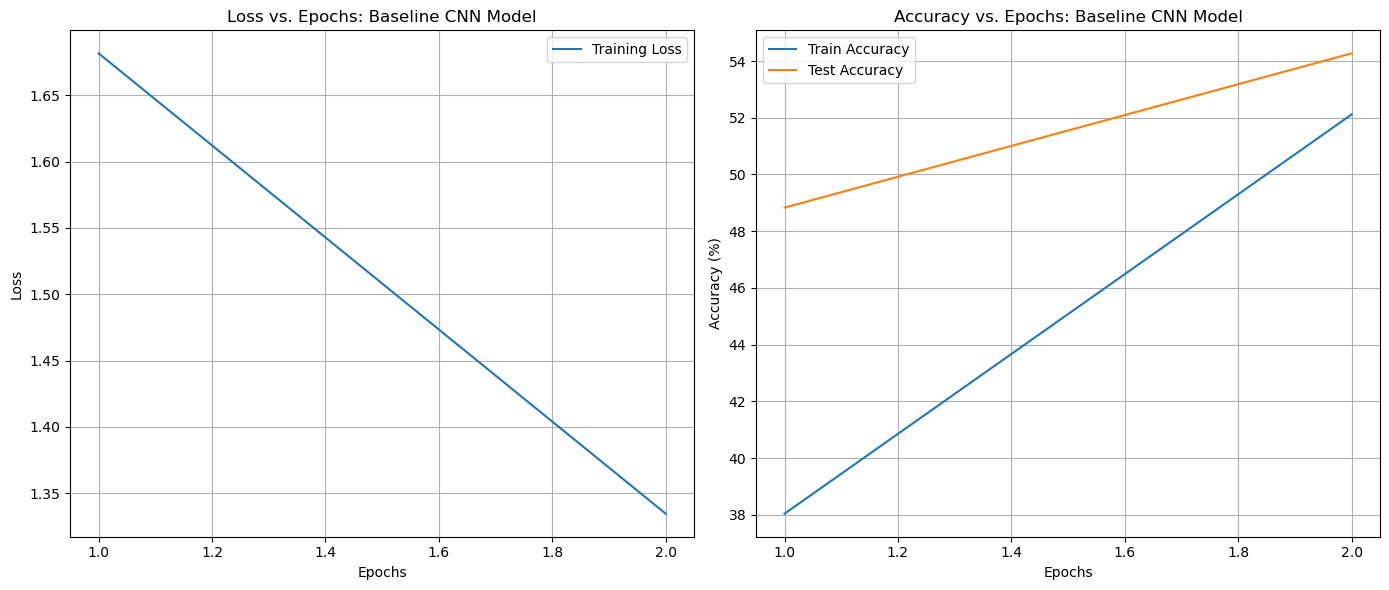

In [ ]:
plot_results("Baseline CNN Model", train_loss_base, train_acc_base, test_acc_base)